In [1]:
import math

import numpy as np
import numpy.random as rng
from scipy.stats import beta, norm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import Tensor
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim

dtype=np.float32

from models.made import GaussianMADE
from models.maf import MaskedAutoregressiveFlow
from models.batch_norm import BatchNorm

# Data

In [55]:
n_train = 10000
n_gen = 10000
n_epochs = 50
batch_size = 20

In [36]:
X_train = np.zeros((n_train, 2))
X_train[:,1] = rng.normal(0.,2.,n_train)
X_train[:,0] = rng.normal(0.25 * X_train[:,1]**2,1.,n_train)

X_validation = np.zeros((n_train, 2))
X_validation[:,1] = rng.normal(0.,2.,n_train)
X_validation[:,0] = rng.normal(0.25 * X_validation[:,1]**2,1.,n_train)

xi = np.linspace(-4.,4.,100)
yi = np.linspace(-4.,4.,100)
xx, yy = np.meshgrid(xi, yi)
X_test = np.array(list(zip(xx.flatten(), yy.flatten())))

p_truth = (norm.pdf(X_test[:,1], 0., 2.)
           * norm.pdf(X_test[:,0], 0.25 * X_test[:,1]**2, 1.))

X_truth = np.zeros((n_gen, 2))
X_truth[:,1] = rng.normal(0.,2.,n_gen)
X_truth[:,0] = rng.normal(0.25 * X_truth[:,1]**2,1.,n_gen)

u_truth = np.zeros((n_gen, 2))
u_truth[:,0] = rng.normal(0.,1.,n_gen)
u_truth[:,1] = rng.normal(0.,1.,n_gen)

# Trainer

In [37]:
def train(model, invert_x_order=False):
    optimizer = optim.Adam(model.parameters())

    print('Beginning training')

    train_losses = []
    validation_losses = []

    for epoch in range(n_epochs):

        train_loss = 0.0
        val_loss = 0.0

        rng.shuffle(X_train)
        rng.shuffle(X_validation)

        # Train batches
        n_batches = int(math.ceil(len(X_train) / batch_size))
        for i in range(n_batches):
            if invert_x_order:
                temp = np.zeros_like(X_train[i*batch_size:(i+1)*batch_size])
                temp[:,0] = X_train[i*batch_size:(i+1)*batch_size,1]
                temp[:,1] = X_train[i*batch_size:(i+1)*batch_size,0]
                batch_train_data = Variable(torch.Tensor(temp))
                temp[:,0] = X_validation[i*batch_size:(i+1)*batch_size,1]
                temp[:,1] = X_validation[i*batch_size:(i+1)*batch_size,0]
                batch_val_data = Variable(torch.Tensor(temp))
            else:
                batch_train_data = Variable(torch.Tensor(X_train[i*batch_size:(i+1)*batch_size]))
                batch_val_data = Variable(torch.Tensor(X_validation[i*batch_size:(i+1)*batch_size]))
            
            optimizer.zero_grad()

            u = model(batch_train_data)
            log_likelihood = model.log_likelihood
            loss = - torch.mean(log_likelihood)
            train_loss += loss.data[0]
            
            loss.backward()
            optimizer.step()

            u = model(batch_val_data)
            log_likelihood = model.log_likelihood
            loss = - torch.mean(log_likelihood)
            val_loss += loss.data[0]

        train_losses.append(train_loss)
        validation_losses.append(val_loss)

        # print statistics
        if epoch % 100 == 99:
            print('Epoch %d: train loss %.3f, validation loss %.3f'
                  % (epoch + 1,  train_losses[-1], validation_losses[-1]))

    print('Finished Training')
    
    return train_losses, validation_losses

# MADE

In [38]:
made = GaussianMADE(n_inputs = 2, n_hiddens = [256])

train_losses, validation_losses = train(made)

Beginning training
Finished Training


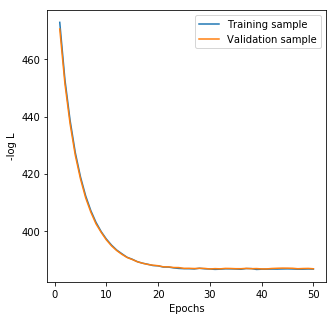

In [39]:
plt.figure(figsize=(5,5))

plt.plot(list(range(1, n_epochs + 1)), train_losses, label='Training sample')
plt.plot(list(range(1, n_epochs + 1)), validation_losses, label='Validation sample')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('-log L')

plt.show()

In [40]:
inputs = Variable(torch.Tensor(X_validation))
u_MADE = made(inputs).data.numpy()

inputs = Variable(torch.Tensor(X_test))
_ = made(inputs)
p_MADE = np.exp(made.log_likelihood.data.numpy().flatten())

X_MADE = made.gen(n_gen)

# MAF

In [56]:
maf = MaskedAutoregressiveFlow(n_inputs = 2, n_hiddens = [200], n_mades = 5, batch_norm=False, alpha=0.1)

train_losses, validation_losses = train(maf)

/Users/johannbrehmer/work/projects/higgs_inference/higgs_inference/prototypes/flow/models/maf.py:38: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  input_order = input_order if input_order == 'random' else made.input_order[::-1]


Beginning training
Finished Training


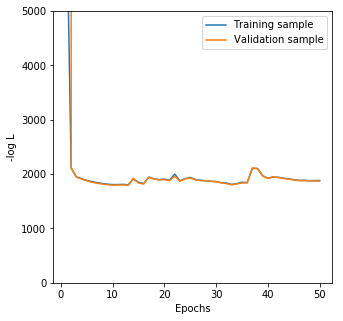

In [63]:
plt.figure(figsize=(5,5))

plt.plot(list(range(1, n_epochs + 1)), train_losses, label='Training sample')
plt.plot(list(range(1, n_epochs + 1)), validation_losses, label='Validation sample')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('-log L')

plt.ylim(0.,5000.)

plt.show()

In [58]:
inputs = Variable(torch.Tensor(X_validation))
u_MAF = maf(inputs, fix_batch_norm=True).data.numpy()

inputs = Variable(torch.Tensor(X_test))
_ = maf(inputs, fix_batch_norm=True)
p_MAF = np.exp(maf.log_likelihood.data.numpy().flatten())

X_MAF = maf.gen(n_gen)

# Show results

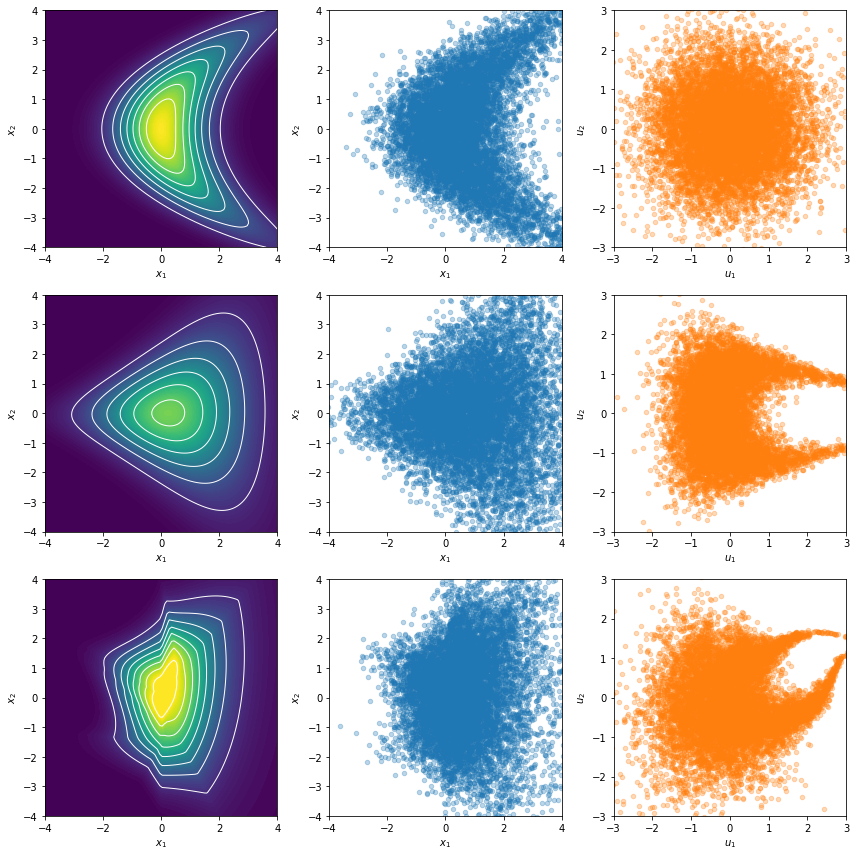

In [59]:
plt.figure(figsize=(12.,12.))
lines = np.linspace(0.0,0.1,11)

plt.subplot(3,3,1)
cs = plt.contourf(xi, yi, p_truth.reshape((100, 100)), 100, cmap="viridis",
                  vmin=0., vmax=0.08)
#cbar = plt.colorbar()
plt.contour(xi, yi, p_truth.reshape((100, 100)), lines,
            linewidths=1., colors='white',
            linestyles='solid')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
#cbar.set_label(r'$p(x)$ (exact)')

plt.subplot(3,3,2)
plt.scatter(X_train[::,0], X_train[::,1,], s=20., alpha=0.3, c='C0')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.subplot(3,3,3)
plt.scatter(u_truth[::,0], u_truth[::,1,], s=20., alpha=0.3, c='C1')
plt.xlim(-3.,3.)
plt.ylim(-3.,3.)
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')

plt.subplot(3,3,4)
cs = plt.contourf(xi, yi, p_MADE.reshape((100, 100)), 100, cmap="viridis",
                  vmin=0., vmax=0.08)
plt.contour(xi, yi, p_MADE.reshape((100, 100)), lines,
            linewidths=1., colors='white',
            linestyles='solid')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.subplot(3,3,5)
plt.scatter(X_MADE[::,0], X_MADE[::,1,], s=20., alpha=0.3, c='C0')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.subplot(3,3,6)
plt.scatter(u_MADE[::,0], u_MADE[::,1], s=20., alpha=0.3, c='C1')
plt.xlim(-3.,3.)
plt.ylim(-3.,3.)
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')

plt.subplot(3,3,7)
cs = plt.contourf(xi, yi, p_MAF.reshape((100, 100)), 100, cmap="viridis",
                  vmin=0., vmax=0.08)
plt.contour(xi, yi, p_MAF.reshape((100, 100)), lines,
            linewidths=1., colors='white',
            linestyles='solid')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.subplot(3,3,8)
plt.scatter(X_MAF[::,0], X_MAF[::,1,], s=20., alpha=0.3, c='C0')
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.subplot(3,3,9)
plt.scatter(u_MAF[::,0], u_MAF[::,1,], s=20., alpha=0.3, c='C1')
plt.xlim(-3.,3.)
plt.ylim(-3.,3.)
plt.xlabel(r'$u_1$')
plt.ylabel(r'$u_2$')

plt.tight_layout()
plt.savefig('figures/MADE_MAF_demo.pdf')